In [54]:
%pip install nltk



[notice] A new release of pip is available: 24.1.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


## 데이터 전처리

In [55]:
import pandas as pd

# 데이터 로드
true_df = pd.read_csv('true.csv')
fake_df = pd.read_csv('fake.csv')

# 진짜 뉴스와 가짜 뉴스에 라벨 추가
true_df['label'] = 1  # 진짜 뉴스는 1로 라벨링
fake_df['label'] = 0  # 가짜 뉴스는 0으로 라벨링

# 두 데이터프레임 병합
data = pd.concat([true_df, fake_df], ignore_index=True)

# 필요 없는 열이 있다면 삭제 (예시: 'id', 'source')
# 실제 데이터셋에 맞춰 제거할 열 이름을 확인하고 수정
columns_to_drop = ['id', 'source']  # 불필요한 열 지정
data.drop(columns=columns_to_drop, inplace=True, errors='ignore')

# 데이터 확인
print(data.head())
print("데이터 컬럼명:", data.columns)

# 결측치 확인
print(data.isnull().sum())



                                               title  \
0  As U.S. budget fight looms, Republicans flip t...   
1  U.S. military to accept transgender recruits o...   
2  Senior U.S. Republican senator: 'Let Mr. Muell...   
3  FBI Russia probe helped by Australian diplomat...   
4  Trump wants Postal Service to charge 'much mor...   

                                                text       subject  \
0  WASHINGTON (Reuters) - The head of a conservat...  politicsNews   
1  WASHINGTON (Reuters) - Transgender people will...  politicsNews   
2  WASHINGTON (Reuters) - The special counsel inv...  politicsNews   
3  WASHINGTON (Reuters) - Trump campaign adviser ...  politicsNews   
4  SEATTLE/WASHINGTON (Reuters) - President Donal...  politicsNews   

                 date  label  
0  December 31, 2017       1  
1  December 29, 2017       1  
2  December 31, 2017       1  
3  December 30, 2017       1  
4  December 29, 2017       1  
데이터 컬럼명: Index(['title', 'text', 'subject', 'date', 'lab

In [56]:
import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import nltk

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

def preprocess_text(text):
    text = text.lower()  # 소문자 변환
    text = re.sub(r'\W', ' ', text)  # 특수문자 제거
    text = re.sub(r'\s+', ' ', text)  # 불필요한 공백 제거
    text = ' '.join([stemmer.stem(word) for word in text.split() if word not in stop_words])  # 불용어 제거 및 어간 추출
    return text

data['text'] = data['text'].apply(preprocess_text)  # 텍스트 열 이름을 실제 데이터 열에 맞게 수정



[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\kweon\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


KeyboardInterrupt: 

In [ ]:
import pandas as pd
import random
from nltk.corpus import wordnet
import nltk

# 필요한 라이브러리 다운로드 (최초 1회 실행 필요)
nltk.download('wordnet')
nltk.download('omw-1.4')

# 동의어 치환 함수
def synonym_replacement(text):
    words = text.split()
    new_words = []
    for word in words:
        synonyms = wordnet.synsets(word)
        if synonyms:
            synonym = synonyms[0].lemmas()[0].name()
            new_words.append(synonym)
        else:
            new_words.append(word)
    return ' '.join(new_words)

# 텍스트 증강 함수 정의
def augment_text(text):
    # 1. 텍스트 역전
    reversed_text = ' '.join(reversed(text.split()))

    # 2. 일부 단어 삭제
    words = text.split()
    num_words_to_remove = max(1, int(0.1 * len(words)))  # 10% 단어 삭제
    drop_text = ' '.join([word for idx, word in enumerate(words) if idx not in random.sample(range(len(words)), num_words_to_remove)])

    # 3. 동의어 치환
    synonym_text = synonym_replacement(text)

    return [reversed_text, drop_text, synonym_text]

# 증강 데이터프레임 생성 및 증강 수행
augmented_rows = []  # 증강된 텍스트를 저장할 리스트
for _, row in data.iterrows():
    augmented_texts = augment_text(row['text'])
    for aug_text in augmented_texts:
        augmented_rows.append({'title': row['title'], 'text': aug_text, 'subject': row['subject'], 'date': row['date'], 'label': row['label']})

# 리스트를 데이터프레임으로 변환
augmented_data = pd.DataFrame(augmented_rows, columns=data.columns)

# 원본 데이터와 증강 데이터 병합
data_augmented = pd.concat([data, augmented_data], ignore_index=True)

# 증강 데이터 확인
print("라벨별 데이터 개수:")
print(data_augmented['label'].value_counts())


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\kweon\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\kweon\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


라벨별 데이터 개수:
label
0    93924
1    85668
Name: count, dtype: int64


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

# 텍스트와 레이블 분리
X_augmented = data_augmented['text']
y_augmented = data_augmented['label']

# 데이터 분할
X_train_aug, X_test_aug, y_train_aug, y_test_aug = train_test_split(X_augmented, y_augmented, test_size=0.2, random_state=42)

# TF-IDF 벡터화
tfidf = TfidfVectorizer(max_features=10000, stop_words='english')
X_train_tfidf_aug = tfidf.fit_transform(X_train_aug)
X_test_tfidf_aug = tfidf.transform(X_test_aug)

# 분할된 데이터 및 TF-IDF 벡터화 결과 확인
print("훈련 데이터 개수:", X_train_aug.shape[0])
print("테스트 데이터 개수:", X_test_aug.shape[0])
print("TF-IDF 벡터화된 훈련 데이터 크기:", X_train_tfidf_aug.shape)
print("TF-IDF 벡터화된 테스트 데이터 크기:", X_test_tfidf_aug.shape)


훈련 데이터 개수: 143673
테스트 데이터 개수: 35919
TF-IDF 벡터화된 훈련 데이터 크기: (143673, 10000)
TF-IDF 벡터화된 테스트 데이터 크기: (35919, 10000)


## 학습

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# XGBoost 하이퍼파라미터 탐색 범위 설정
xgb_param_dist = {
    'max_depth': [4, 5, 6],
    'learning_rate': [0.1, 0.2, 0.3],
    'n_estimators': [150, 200, 250],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.4, 0.5, 0.6],
    'gamma': [0, 0.1, 0.2]
}

# LightGBM 하이퍼파라미터 탐색 범위 설정
lgb_param_dist = {
    'max_depth': [5.5, 6, 6.5],
    'learning_rate': [0.07, 0.08, 0.09],
    'n_estimators': [165, 168, 170],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.45, 0.5, 0.55]
}

# RandomizedSearchCV를 사용하여 XGBoost 최적 하이퍼파라미터 찾기
xgb_model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
xgb_random_search = RandomizedSearchCV(estimator=xgb_model, param_distributions=xgb_param_dist, n_iter=10, scoring='accuracy', cv=3, n_jobs=-1, random_state=42, verbose=1)
xgb_random_search.fit(X_train_tfidf_aug, y_train_aug)  # 증강 데이터셋 사용

print("Best XGBoost Hyperparameters:", xgb_random_search.best_params_)
print("Best XGBoost Accuracy:", xgb_random_search.best_score_)

# RandomizedSearchCV를 사용하여 LightGBM 최적 하이퍼파라미터 찾기
lgb_model = LGBMClassifier(random_state=42)
lgb_random_search = RandomizedSearchCV(estimator=lgb_model, param_distributions=lgb_param_dist, n_iter=10, scoring='accuracy', cv=3, n_jobs=-1, random_state=42, verbose=1)
lgb_random_search.fit(X_train_tfidf_aug, y_train_aug)  # 증강 데이터셋 사용

print("Best LightGBM Hyperparameters:", lgb_random_search.best_params_)
print("Best LightGBM Accuracy:", lgb_random_search.best_score_)


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\kweon\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:34:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best XGBoost Hyperparameters: {'subsample': 0.8, 'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.3, 'gamma': 0.1, 'colsample_bytree': 0.4}
Best XGBoost Accuracy: 0.9974734292455785
Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\kweon\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
15 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
9 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\kweon\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\kweon\AppData\Local\Programs\Python\Python312\Lib\site-packages\lightgbm\sklearn.py", line 1284, in fit
    super().fit(
  File "c:\Users\kweon\AppData\Local\Programs\Python\Python312\Lib\site-packages\lightgbm\sklearn.py", line 955, 

[LightGBM] [Info] Number of positive: 68688, number of negative: 74985
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.075455 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1572914
[LightGBM] [Info] Number of data points in the train set: 143673, number of used features: 9985
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.478086 -> initscore=-0.087714
[LightGBM] [Info] Start training from score -0.087714
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positi

In [ ]:
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import joblib


# 평가 함수 정의
def evaluate_model(y_test, y_pred, model_name="Model"):
    print(f"{model_name} - Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print(f"{model_name} - Classification Report:\n{classification_report(y_test, y_pred)}")
    print(f"{model_name} - Confusion Matrix:\n{confusion_matrix(y_test, y_pred)}\n")

# XGBoost 모델 학습
xgb_model = XGBClassifier(
    colsample_bytree=0.4,
    gamma=0.1,
    learning_rate=0.3,
    max_depth=5,
    n_estimators=200,
    subsample=0.8,
    random_state=42
)
xgb_model.fit(X_train_tfidf_aug, y_train_aug)  # 증강된 데이터로 학습
y_pred_xgb = xgb_model.predict(X_test_tfidf_aug)  # 증강된 테스트 데이터로 예측
evaluate_model(y_test_aug, y_pred_xgb, "XGBoost")  # 모델 평가

# LightGBM 모델 학습
lgb_model = LGBMClassifier(
    colsample_bytree=0.5,
    learning_rate=0.09,
    max_depth=6,
    n_estimators=170,
    subsample=1.0,
    random_state=42
)
lgb_model.fit(X_train_tfidf_aug, y_train_aug)  # 증강된 데이터로 학습
y_pred_lgb = lgb_model.predict(X_test_tfidf_aug)  # 증강된 테스트 데이터로 예측
evaluate_model(y_test_aug, y_pred_lgb, "LightGBM")  # 모델 평가

# XGBoost 모델 저장
joblib.dump(xgb_model, 'xgb_model.pkl')
print("XGBoost 모델이 저장되었습니다.")

# LightGBM 모델 저장
joblib.dump(lgb_model, 'lgb_model.pkl')
print("LightGBM 모델이 저장되었습니다.")


XGBoost - Accuracy: 0.9944
XGBoost - Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     18939
           1       1.00      0.99      0.99     16980

    accuracy                           0.99     35919
   macro avg       0.99      0.99      0.99     35919
weighted avg       0.99      0.99      0.99     35919

XGBoost - Confusion Matrix:
[[18894    45]
 [  156 16824]]

[LightGBM] [Info] Number of positive: 68688, number of negative: 74985
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.204865 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1572914
[LightGBM] [Info] Number of data points in the train set: 143673, number of used features: 9985
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.478086 -> initscore=-0.087714
[LightGBM] [Info] Start training from score -0.087714
[LightGBM] [Warning] No further splits with positive 

In [ ]:
from sklearn.ensemble import VotingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import joblib

# 최적 하이퍼파라미터를 설정한 모델 초기화
xgb_model = XGBClassifier(
    colsample_bytree=0.4,
    gamma=0.1,
    learning_rate=0.3,
    max_depth=5,
    n_estimators=200,
    subsample=0.8,
    random_state=42
)

lgb_model = LGBMClassifier(
    colsample_bytree=0.5,
    learning_rate=0.09,
    max_depth=6,
    n_estimators=170,
    subsample=1.0,
    random_state=42
)

# 개별 모델 학습
xgb_model.fit(X_train_tfidf_aug, y_train_aug)
lgb_model.fit(X_train_tfidf_aug, y_train_aug)

# 개별 모델을 파일로 저장
joblib.dump(xgb_model, 'xgb_model.pkl')
print("XGBoost 모델이 저장되었습니다.")
joblib.dump(lgb_model, 'lgb_model.pkl')
print("LightGBM 모델이 저장되었습니다.")

# VotingClassifier를 사용해 두 모델을 앙상블
ensemble_model = VotingClassifier(
    estimators=[('xgb', xgb_model), ('lgb', lgb_model)],
    voting='soft'  # 'soft'는 예측 확률을 평균
)

# 앙상블 모델 학습
ensemble_model.fit(X_train_tfidf_aug, y_train_aug)

# 예측 및 평가
y_pred_ensemble = ensemble_model.predict(X_test_tfidf_aug)
print("Ensemble Model - Accuracy:", accuracy_score(y_test_aug, y_pred_ensemble))
print("Ensemble Model - Classification Report:\n", classification_report(y_test_aug, y_pred_ensemble))
print("Ensemble Model - Confusion Matrix:\n", confusion_matrix(y_test_aug, y_pred_ensemble))

# 앙상블 모델 저장
joblib.dump(ensemble_model, 'ensemble_model.pkl')
print("Ensemble 모델이 저장되었습니다.")


[LightGBM] [Info] Number of positive: 68688, number of negative: 74985
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.065913 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1572914
[LightGBM] [Info] Number of data points in the train set: 143673, number of used features: 9985
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.478086 -> initscore=-0.087714
[LightGBM] [Info] Start training from score -0.087714
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positi

## 평가

In [ ]:
from sklearn.metrics import accuracy_score, classification_report

# 학습 데이터와 테스트 데이터에 대한 성능 평가 함수
def check_overfitting(model, X_train, y_train, X_test, y_test, model_name="Model"):
    # 학습 데이터 성능
    y_train_pred = model.predict(X_train)
    train_accuracy = accuracy_score(y_train, y_train_pred)
    
    # 테스트 데이터 성능
    y_test_pred = model.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    
    # 결과 출력
    print(f"{model_name} - Training Accuracy: {train_accuracy:.4f}")
    print(f"{model_name} - Test Accuracy: {test_accuracy:.4f}")
    print("\nClassification Report on Test Data:")
    print(classification_report(y_test, y_test_pred))
    
    # 오버피팅 확인
    if train_accuracy - test_accuracy > 0.05:  # 학습 정확도가 테스트 정확도보다 5% 이상 높을 경우
        print(f"Warning: {model_name} might be overfitting!\n")
    else:
        print(f"{model_name} does not show significant signs of overfitting.\n")

# XGBoost 오버피팅 확인
check_overfitting(xgb_model, X_train_tfidf_aug, y_train_aug, X_test_tfidf_aug, y_test_aug, "XGBoost")

# LightGBM 오버피팅 확인
check_overfitting(lgb_model, X_train_tfidf_aug, y_train_aug, X_test_tfidf_aug, y_test_aug, "LightGBM")

# Ensemble Model 오버피팅 확인
check_overfitting(ensemble_model, X_train_tfidf_aug, y_train_aug, X_test_tfidf_aug, y_test_aug, "Ensemble Model")


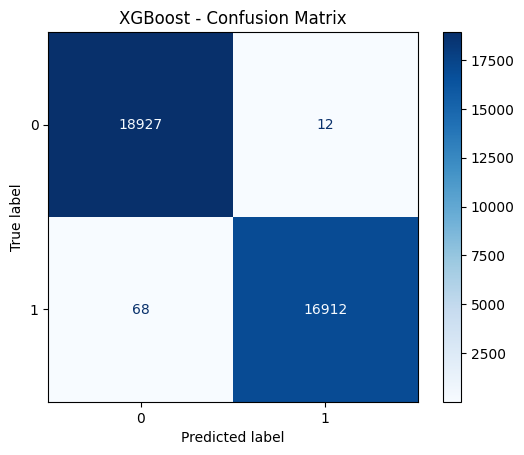

XGBoost - Evaluation Metrics:
  Accuracy: 0.9978
  Precision: 0.9993
  Recall: 0.9960
  F1 Score: 0.9976




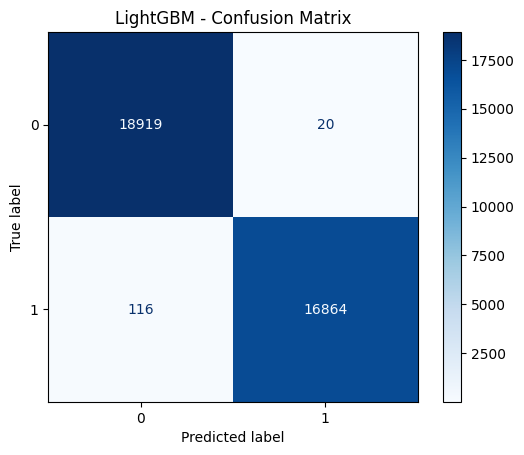

LightGBM - Evaluation Metrics:
  Accuracy: 0.9962
  Precision: 0.9988
  Recall: 0.9932
  F1 Score: 0.9960




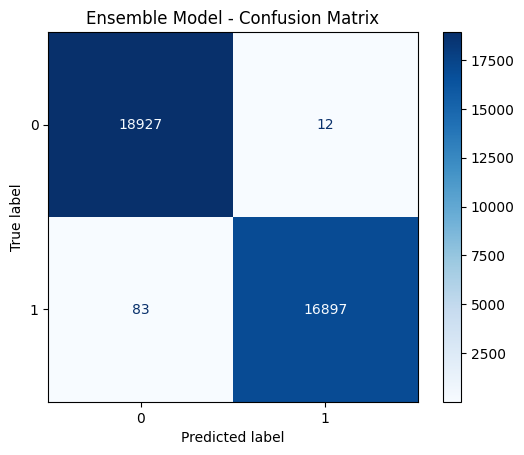

Ensemble Model - Evaluation Metrics:
  Accuracy: 0.9974
  Precision: 0.9993
  Recall: 0.9951
  F1 Score: 0.9972




In [ ]:
import joblib
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# 저장된 모델 불러오기
xgb_model = joblib.load('xgb_model.pkl')
lgb_model = joblib.load('lgb_model.pkl')
ensemble_model = joblib.load('ensemble_model.pkl')

# 각 모델의 예측 결과 계산
y_pred_xgb = xgb_model.predict(X_test_tfidf_aug)
y_pred_lgb = lgb_model.predict(X_test_tfidf_aug)
y_pred_ensemble = ensemble_model.predict(X_test_tfidf_aug)

# 혼동 행렬 및 평가 지표를 출력하는 함수 정의
def plot_confusion_matrix_with_metrics(y_test, y_pred, model_name="Model"):
    # 혼동 행렬 계산 및 출력
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f"{model_name} - Confusion Matrix")
    plt.show()
    
    # 평가 지표 계산
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    # 평가 지표 출력
    print(f"{model_name} - Evaluation Metrics:")
    print(f"  Accuracy: {accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall: {recall:.4f}")
    print(f"  F1 Score: {f1:.4f}")
    print("\n")

# 혼동 행렬 및 평가 지표 표시
plot_confusion_matrix_with_metrics(y_test_aug, y_pred_xgb, "XGBoost")
plot_confusion_matrix_with_metrics(y_test_aug, y_pred_lgb, "LightGBM")
plot_confusion_matrix_with_metrics(y_test_aug, y_pred_ensemble, "Ensemble Model")


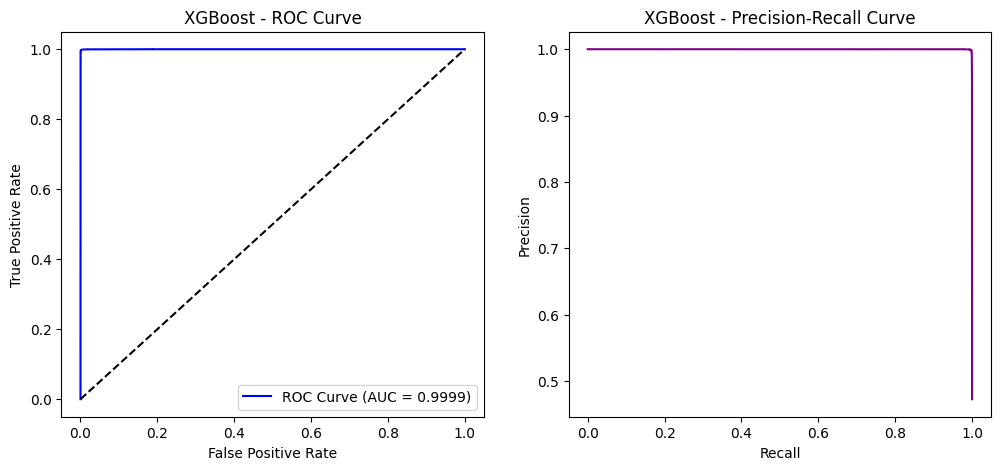

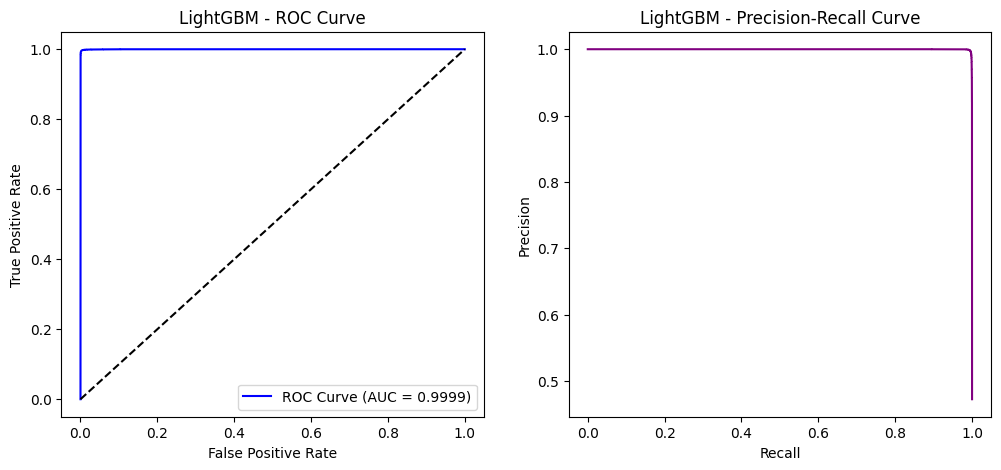

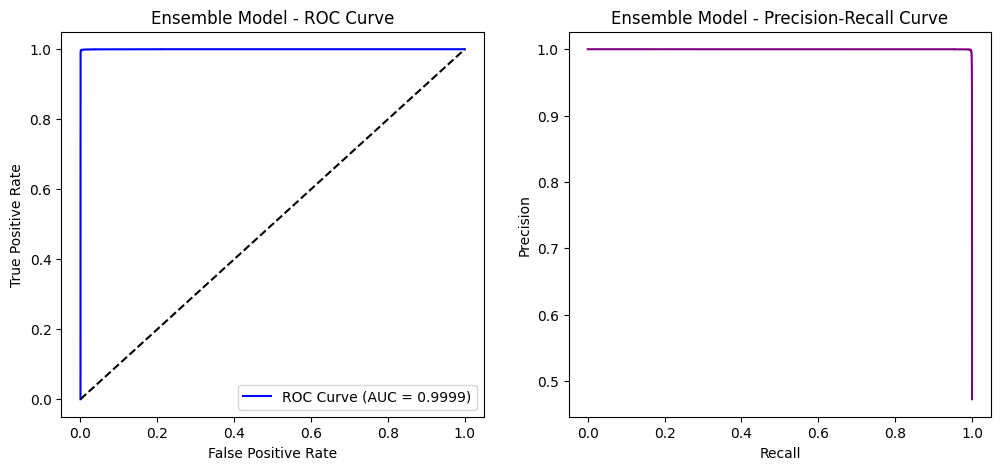

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve
import matplotlib.pyplot as plt

# ROC-AUC 및 Precision-Recall Curve 그리기 함수
def plot_evaluation_curves(y_test, y_pred_proba, model_name="Model"):
    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba[:, 1])
    auc_score = roc_auc_score(y_test, y_pred_proba[:, 1])
    
    plt.figure(figsize=(12, 5))
    
    # ROC Curve
    plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {auc_score:.4f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f"{model_name} - ROC Curve")
    plt.legend(loc="lower right")
    
    # Precision-Recall Curve
    plt.subplot(1, 2, 2)
    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba[:, 1])
    plt.plot(recall, precision, color='purple')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f"{model_name} - Precision-Recall Curve")
    
    plt.show()

# 각 모델에 대한 평가 및 그래프 생성
# XGBoost 모델 평가
y_pred_proba_xgb = xgb_model.predict_proba(X_test_tfidf_aug)  # 증강된 테스트 데이터 사용
plot_evaluation_curves(y_test_aug, y_pred_proba_xgb, "XGBoost")

# LightGBM 모델 평가
y_pred_proba_lgb = lgb_model.predict_proba(X_test_tfidf_aug)  # 증강된 테스트 데이터 사용
plot_evaluation_curves(y_test_aug, y_pred_proba_lgb, "LightGBM")

# 앙상블 모델 평가
y_pred_proba_ensemble = ensemble_model.predict_proba(X_test_tfidf_aug)  # 증강된 테스트 데이터 사용
plot_evaluation_curves(y_test_aug, y_pred_proba_ensemble, "Ensemble Model")


In [58]:
from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# XGBoost와 LightGBM 모델 정의 (이전 최적 하이퍼파라미터 사용)
xgb_model = XGBClassifier(
    colsample_bytree=0.6,
    gamma=0,
    learning_rate=0.1,
    max_depth=5,
    n_estimators=150,
    subsample=0.9,
    random_state=42
)

lgb_model = LGBMClassifier(
    colsample_bytree=0.55,
    learning_rate=0.09,
    max_depth=6,
    n_estimators=168,
    subsample=0.7,
    random_state=42
)

# K-겹 교차 검증 설정
k = 5  # 5-겹 교차 검증을 수행합니다.

# XGBoost 교차 검증
xgb_scores = cross_val_score(xgb_model, X_train_tfidf_aug, y_train_aug, cv=k, scoring='accuracy')
print("XGBoost Cross-Validation Scores:", xgb_scores)
print("XGBoost Mean Accuracy:", xgb_scores.mean())

# LightGBM 교차 검증
lgb_scores = cross_val_score(lgb_model, X_train_tfidf_aug, y_train_aug, cv=k, scoring='accuracy')
print("LightGBM Cross-Validation Scores:", lgb_scores)
print("LightGBM Mean Accuracy:", lgb_scores.mean())

# 과적합 여부 판단
print("\n교차 검증 결과를 기반으로 과적합 여부를 판단해보세요.")
print("각 모델의 교차 검증 평균 정확도가 테스트 정확도와 크게 차이가 나지 않는다면 과적합이 아닐 가능성이 높습니다.")


XGBoost Cross-Validation Scores: [0.9952671  0.99394467 0.99474508 0.99422287 0.99505812]
XGBoost Mean Accuracy: 0.9946475676421865
[LightGBM] [Info] Number of positive: 54950, number of negative: 59988
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.798276 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1441274
[LightGBM] [Info] Number of data points in the train set: 114938, number of used features: 9979
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.478084 -> initscore=-0.087721
[LightGBM] [Info] Start training from score -0.087721
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

In [ ]:
LightGBM Mean Accuracy: 0.9958168879005378